<a href="https://colab.research.google.com/github/martinpius/Computer-Vission/blob/main/YOLO_DarkNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
try: 
  COLAB = True
  import tensorflow as tf
  print(f"You are in CoLab with tensorflow version: {tf.__version__}")
except Exception as e:
  print(f"{type(e)}: {e}\n....please load your drive...")
  COLAB = False
def time_fmt(t:float = 123.45739)->float:
  h = int(t / (60 * 60))
  m = int(t % (60 * 60) / 60)
  s = int(t % 60)
  return f"{h}: {m:>03}: {s:>05.2f}"
print(f"....testing....testing....testing...\ntime elapse in seconds: {time_fmt()}")

Mounted at /content/drive
You are in CoLab with tensorflow version: 2.4.1
....testing....testing....testing...
time elapse in seconds: 0: 002: 03.00


In [50]:
import sys
!{sys.executable} -m pip install \
  git+https://github.com/zzh8829/yolov3-tf2.git@master

  Cloning https://github.com/zzh8829/yolov3-tf2.git (to revision master) to /tmp/pip-req-build-s4thzpxr
  Running command git clone -q https://github.com/zzh8829/yolov3-tf2.git /tmp/pip-req-build-s4thzpxr
  Created wheel for yolov3-tf2: filename=yolov3_tf2-0.1-cp37-none-any.whl size=8844 sha256=27294891eb1e5bee0ab0de57a21ac586eb12060657373451f74ec0ff331b8887
  Stored in directory: /tmp/pip-ephem-wheel-cache-h7hjeu31/wheels/59/1b/97/905ab51e9c0330efe8c3c518aff17de4ee91100412cd6dd553
Successfully built yolov3-tf2


In [51]:
#Downloading the weights, classes and convertor for which YOLO was originally trained. 

In [52]:
import tensorflow as tf
from yolov3_tf2.models import YoloV3, YoloV3Tiny
from yolov3_tf2.dataset import transform_images, load_tfrecord_dataset
from yolov3_tf2.utils import draw_outputs
import os, time
import numpy as np
import cv2
import PIL,requests, sys
from PIL import Image, ImageFile
from absl import app, flags, logging
from absl.flags import FLAGS

if COLAB:
  ROOT = "/content/drive/MyDrive/images"
else:
  ROOT = os.path.join(os.getcwd(), 'data')
darknet_wts_fname = tf.keras.utils.get_file(os.path.join(ROOT, 'yolov3_weights'),
                    origin = "https://pjreddie.com/media/files/yolov3.weights")
TINY = False
convert_script_fname = tf.keras.utils.get_file(
  os.path.join(os.getcwd(), 'convert.py'),
  origin = "https://raw.githubusercontent.com/zzh8829/"\
      "yolov3-tf2/master/convert.py")
fname_classes = tf.keras.utils.get_file(
    os.path.join(ROOT, 'coco_names'), 
  origin = "https://raw.githubusercontent.com/zzh8829/"\
      "yolov3-tf2/master/data/coco.names")
fname_converted_wts = os.path.join(ROOT, 'yolov3.tf')



8192/1277 [================================================================================================================================================================================================] - 0s 0us/step


In [53]:
#Coverting the YOLO weights to be recognized by tensorflow

In [54]:
!{sys.executable} "{convert_script_fname}" --weights \
    "{darknet_wts_fname}" --output "{fname_converted_wts}"

2021-03-08 21:33:41.258094: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-03-08 21:33:42.931525: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-03-08 21:33:42.932504: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-03-08 21:33:42.940673: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-03-08 21:33:42.941069: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P4 computeCapability: 6.1
coreClock: 1.1135GHz coreCount: 20 deviceMemorySize: 7.43GiB deviceMemoryBandwidth: 178.99GiB/s
2021-03-08 21:33:42.941122: I tensorflow/stream_executor/platform/default/dso_load

In [55]:
os.remove(convert_script_fname) #We delete this file as we already have the tensorflow version of it

In [56]:
#Defining options using flags:

In [57]:
flags.DEFINE_string('classes', fname_classes, 'path to classes file')
flags.DEFINE_string('weights',fname_converted_wts, \
                    'path to weights file')
flags.DEFINE_boolean('tiny', False, 'yolov3 or yolov3-tiny')
flags.DEFINE_integer('size', 416, 'resize images to')
flags.DEFINE_string('tfrecord', None, 'tfrecord instead of image')
flags.DEFINE_integer('num_classes', 80, 'number of classes in the model')
FLAGS([sys.argv[0]])

DuplicateFlagError: ignored

In [ ]:
#Alocate the GPU to run the model
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [58]:
if FLAGS.tiny:
    yolo = YoloV3Tiny(classes=FLAGS.num_classes)
else:
    yolo = YoloV3(classes=FLAGS.num_classes)

# Load weights and classes
yolo.load_weights(FLAGS.weights).expect_partial()
print('weights loaded')

class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
print('classes loaded')

weights loaded
classes loaded


In [65]:
url = "https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/small-kitchen-1572367025.png"
response = requests.get(url)
my_image = tf.image.decode_image(response.content, channels=3)

In [66]:
# Preprocess the image by reshaping to meet the YOLO darknet specification
img = tf.expand_dims(my_image, 0)
img = transform_images(img, FLAGS.size)

# Desired threshold (any sub-image below this confidence 
# level will be ignored.)
FLAGS.yolo_score_threshold = 0.5

# Recognize and report results
tic = time.time()
boxes, scores, classes, nums = yolo(img)
toc = time.time()
print(f"time elapsed for the prediction: {time_fmt(toc - tic)}")

time elapsed for the prediction: 0: 000: 00.00


In [67]:
print('items detected on the above image are:')
for i in range(nums[0]):
    cls = class_names[int(classes[0][i])]
    score = np.array(scores[0][i])
    box = np.array(boxes[0][i])
    print(f"\t{cls}, {score}, {box}")

items detected on the above image are:
	chair, 0.9966289401054382, [0.7022241 0.5965799 0.876069  0.922078 ]
	chair, 0.9729472398757935, [0.86281717 0.56512254 0.99053335 0.8360916 ]
	chair, 0.9325485825538635, [0.57747227 0.5983491  0.7117931  0.88998854]
	oven, 0.8851966261863708, [0.13523674 0.5235842  0.37861466 0.8041499 ]
	pottedplant, 0.8435614705085754, [0.60886455 0.5310806  0.6506932  0.5738441 ]
	pottedplant, 0.8389180302619934, [0.62659615 0.4026061  0.7133201  0.5621591 ]
	bowl, 0.8243888020515442, [0.60921675 0.54916936 0.65111023 0.573682  ]
	vase, 0.8058382868766785, [0.42731994 0.48986334 0.4442932  0.531565  ]
	pottedplant, 0.7398949265480042, [0.4074523 0.424865  0.4844783 0.5324091]
	bottle, 0.71723473072052, [0.08954091 0.47309095 0.11359498 0.56048626]
	bowl, 0.7155634164810181, [0.74547213 0.32355103 0.7881836  0.34989914]
	vase, 0.7046646475791931, [0.76128286 0.5391795  0.78606945 0.56582886]
	sofa, 0.6720239520072937, [0.00240485 0.64670205 0.23583168 0.999576

In [68]:
#We can print the image with imbeded boxes to real see how the model was accurate in detection

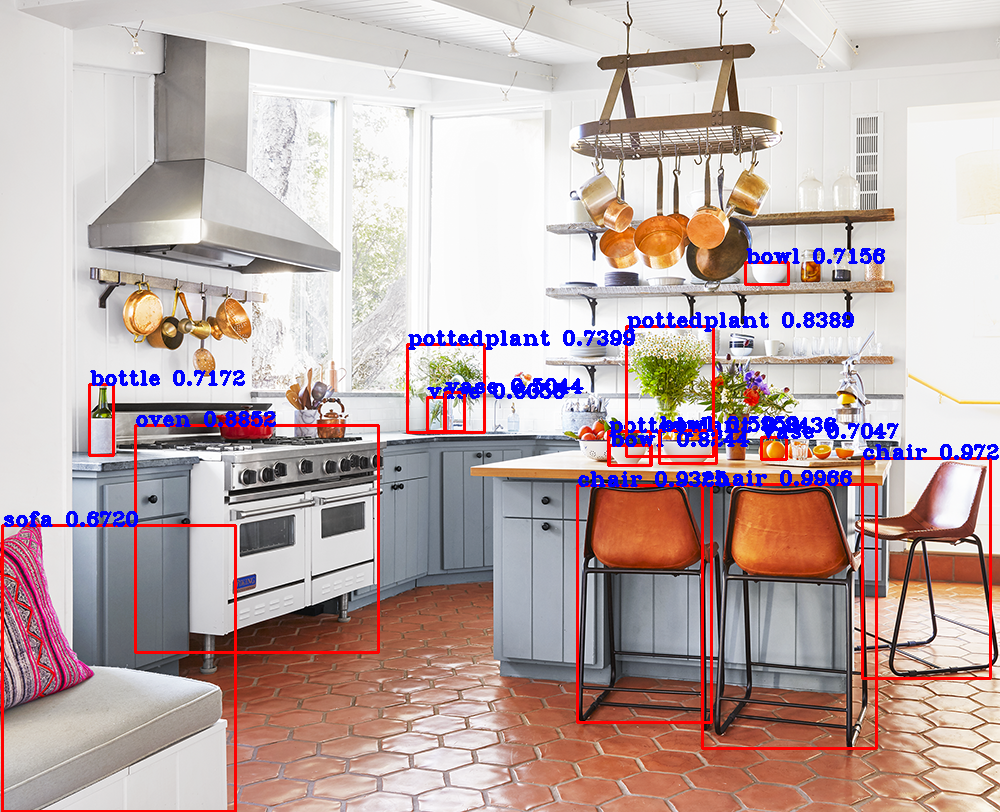

In [69]:
img = my_image.numpy()
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)
#cv2.imwrite(FLAGS.output, img) # Save the image
display(Image.fromarray(img, 'RGB')) # Display the image